# Tracking the spread of 2019 Coronavirus

來源: [https://www.kaggle.com/gpreda/tracking-the-spread-of-2019-coronavirus](https://www.kaggle.com/gpreda/tracking-the-spread-of-2019-coronavirus)

此筆記使用多個資料集裡的內容進行分析，包括:

- [China Region Map](https://www.kaggle.com/gpreda/china-regions-map)

- [Coronavirus 2019-nCoV](https://www.kaggle.com/gpreda/coronavirus-2019ncov)

- [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)

- [Python Folium Country Boundaries](https://www.kaggle.com/subota/python-folio-country-boundaries)

- [UNCOVER COVID-19 Challenge](https://www.kaggle.com/roche-data-science-coalition/uncover)

因為中國是疫情發源地，所以先分析中國的染病、痊癒、死亡狀況，再來探討病毒在全世界的進展。此外，作者利用數個國家的對數曲線監測國家量級的疫情成長，並且用熱圖繪製出各地區的確診跟死亡數

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, HeatMapWithTime
import datetime as dt
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 08/06/2020


印出資料夾內容

In [3]:
print(os.listdir('./input'))
DATA_FOLDER = "./input/coronavirus-2019ncov"
print(os.listdir(DATA_FOLDER))
GEO_DATA = "./input/china-regions-map"
print(os.listdir(GEO_DATA))
WD_GEO_DATA = './input/python-folio-country-boundaries'
print(os.listdir(WD_GEO_DATA))

['china-regions-map', 'coronavirus-2019ncov', 'python-folio-country-boundaries']
['covid-19-all.csv']
['china-provinces.json', 'china.json']
['world-countries.json']


## 載入資料

- `data_df` : dataframe 儲存從 1/22 到 5/27 各地區的: 國家,地區,經度,緯度,確診,痊癒,死亡,日期

- `cn_geo_data` : geojason 儲存中國各省的地理位置

- `wd_geo_data` : geojason 儲存各國地理位置

In [4]:
data_df = pd.read_csv(os.path.join(DATA_FOLDER, "covid-19-all.csv"))
cn_geo_data = os.path.join(GEO_DATA, "china.json")
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")

## 分析中國資料 

## (可以不用看，作者沒有多做評論，只有估計死亡率3%，而且沒驗證，實際上是5.5%至5.8%)

觀察 `data_df` 的各個屬性

In [5]:
print('Rows:', data_df.shape[0], 'Columns:',data_df.shape[1])

Rows: 218943 Columns: 8


In [6]:
data_df.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,China,Anhui,31.8257,117.2264,1.0,NaN,NaN,2020-01-22
1,China,Beijing,40.1824,116.4142,14.0,NaN,NaN,2020-01-22
2,China,Chongqing,30.0572,107.8740,6.0,NaN,NaN,2020-01-22
3,China,Fujian,26.0789,117.9874,1.0,NaN,NaN,2020-01-22
4,China,Gansu,37.8099,101.0583,NaN,NaN,NaN,2020-01-22


In [7]:
data_df.tail()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
218938,West Bank and Gaza,NaN,31.952200,35.233200,434.0,365.0,3.0,2020-05-27
218939,Western Sahara,NaN,24.215500,-12.885800,9.0,6.0,1.0,2020-05-27
218940,Yemen,NaN,15.552727,48.516388,256.0,10.0,53.0,2020-05-27
218941,Zambia,NaN,-13.133897,27.849332,1057.0,779.0,7.0,2020-05-27
218942,Zimbabwe,NaN,-19.015438,29.154857,132.0,25.0,4.0,2020-05-27


In [8]:
for column in data_df.columns:
    print(column, ':', data_df[column].dtype)
print(f"\nDate unique: {data_df['Date'].nunique()} days ({min(data_df['Date'])} - {max(data_df['Date'])})")

Country/Region : object
Province/State : object
Latitude : float64
Longitude : float64
Confirmed : float64
Recovered : float64
Deaths : float64
Date : object

Date unique: 127 days (2020-01-22 - 2020-05-27)


將日期格式轉換為 datetime64

In [9]:
data_df['Date'] = pd.to_datetime(data_df['Date'])
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")
print(f"\nDate unique: {data_df['Date'].nunique()} days ({min(data_df['Date'])} - {max(data_df['Date'])})")

Country/Region:object
Province/State:object
Latitude:float64
Longitude:float64
Confirmed:float64
Recovered:float64
Deaths:float64
Date:datetime64[ns]

Date unique: 127 days (2020-01-22 00:00:00 - 2020-05-27 00:00:00)


觀察 `data_df` 各欄位的空值數量，並計算該欄位的空值和所有值的百分比

In [10]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [11]:
missing_data(data_df)

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
Total,0,15255,1,1,19,388,441,0
Percent,0,6.96757,0.00045674,0.00045674,0.00867806,0.177215,0.201422,0
Types,object,object,float64,float64,float64,float64,float64,datetime64[ns]


觀察 `data_df` 國家及州省的數量

In [12]:
print(f"Countries/Regions: {data_df['Country/Region'].nunique()}")
print(f"Province/State:    {data_df['Province/State'].nunique()}")

Countries/Regions: 215
Province/State:    430


觀察中國地圖的 GeoJSON，(wd_geo_data 會在中國各省描繪出藍色框框)，但是把台灣也包含進來了 =_=

這個只是用來測試的 code ，後面也會使用到一樣的套件所以先不用看

In [13]:
# ch_map = folium.Map(location=[35, 100], zoom_start=4)

# folium.GeoJson(
    
#     # 使用此程式碼會出現 cp-950 encoding 的問題，所以改成 open(...) 的寫法，強制使用 utf-8 解碼
#     open(cn_geo_data, encoding = "utf-8-sig").read(),
    
#     name='geojson'
# ).add_to(ch_map)

# folium.LayerControl().add_to(ch_map)

# ch_map

觀察世界地圖的 GeoJSON，(wd_geo_data 會在國家周圍描繪出藍色框框)

In [14]:
# wd_map = folium.Map(location=[0,0], zoom_start=2)

# folium.GeoJson(
#     wd_geo_data,
#     name='geojson'
# ).add_to(wd_map)

# folium.LayerControl().add_to(wd_map)

# wd_map

將中國的資料 (不含台港澳) 從 `data_df` 抽出來另外存入 `data_cn` 然後將日期由新到舊排序，再將 `data_cn` 中最新日期 (5/27) 的資料存入 `filtered_data_last`

In [15]:
data_cn = data_df.loc[data_df['Country/Region'] == "China"]
data_cn = data_cn.sort_values(by = ['Province/State', 'Date'], ascending = False)
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'], keep = 'first')

繪製至 5/27 為止中國前 30 高的省、市的確診數

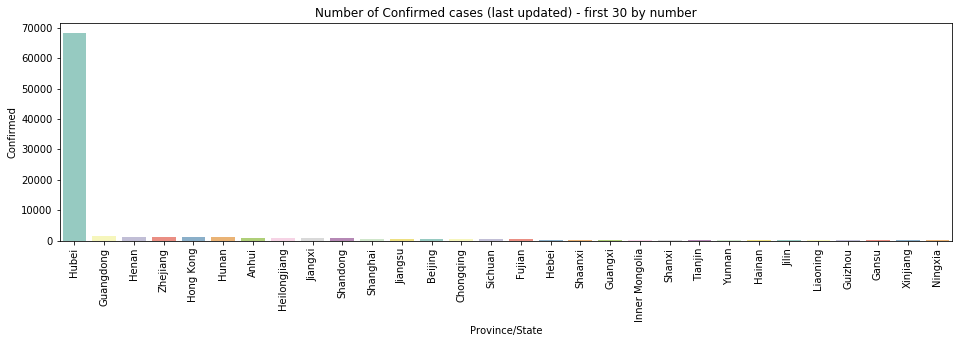

In [16]:
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 4))
    df = df.sort_values([value], ascending=False).reset_index(drop = True)
    g = sns.barplot(df[feature][0:30], df[value][0:30], palette = 'Set3')
    g.set_title("Number of {} - first 30 by number".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()

plot_count('Province/State', 'Confirmed', 'Confirmed cases (last updated)', filtered_data_last, size=4)

In [17]:
def plot_time_variation(df, y = 'Confirmed', hue = 'Province/State', size = 1, is_log = True):
    f, ax = plt.subplots(1, 1, figsize = (4 * size, 3 * size))
    g = sns.lineplot(x = "Date", y = y, hue = hue, data = df)
    plt.xticks(rotation = 90)
    plt.title(f'{y} cases grouped by {hue}')
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    plt.show()

中國各省確診數的累積圖，確診數以對數表示

C:\Users\Lin\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


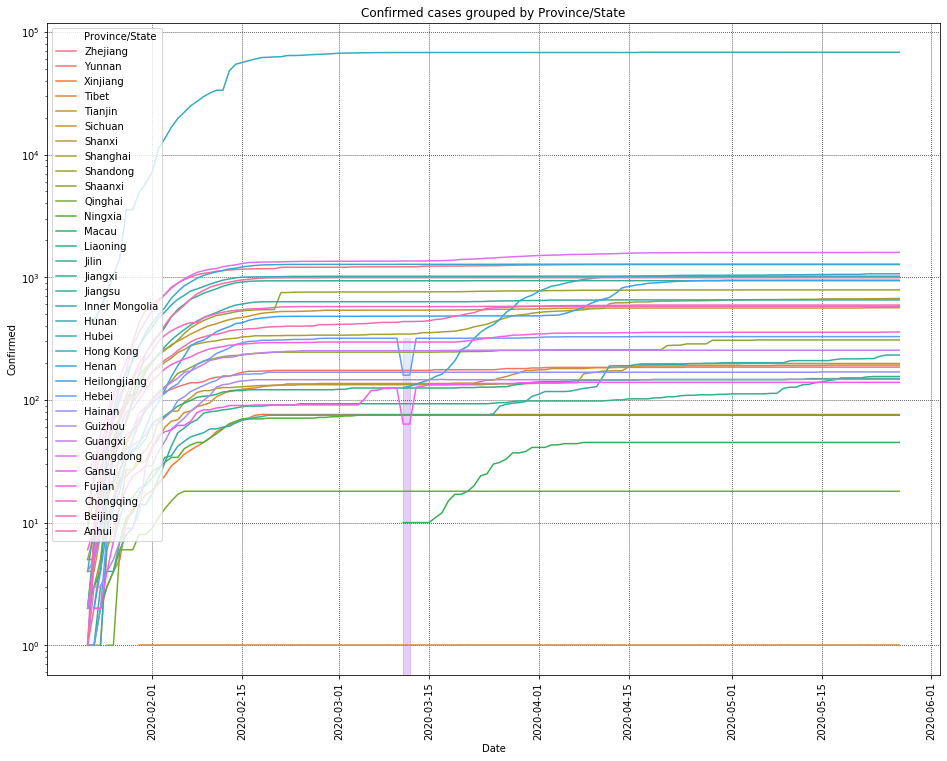

In [18]:
plot_time_variation(data_cn, size = 4, is_log = True)

中國各省痊癒數的累積圖，以對數表示

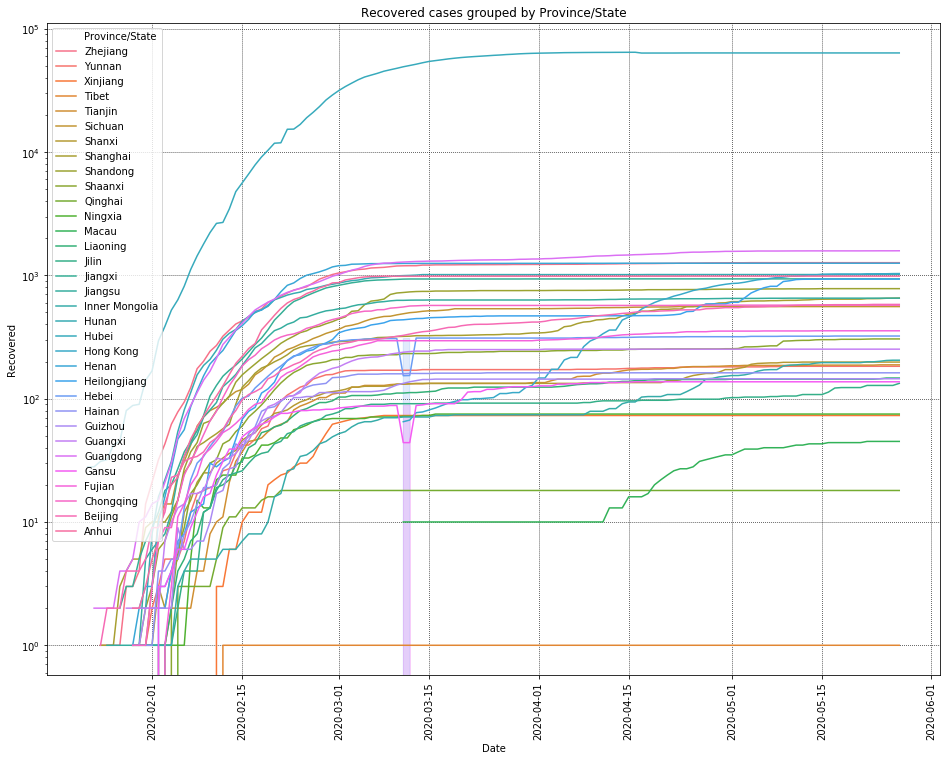

In [19]:
plot_time_variation(data_cn, y='Recovered', size=4, is_log=True)

將 `data_cn` 裡同樣日期的欄位合併放入另一個變數 `data_cn_agg`，觀察中國的總累積圖，以資料原始值表示

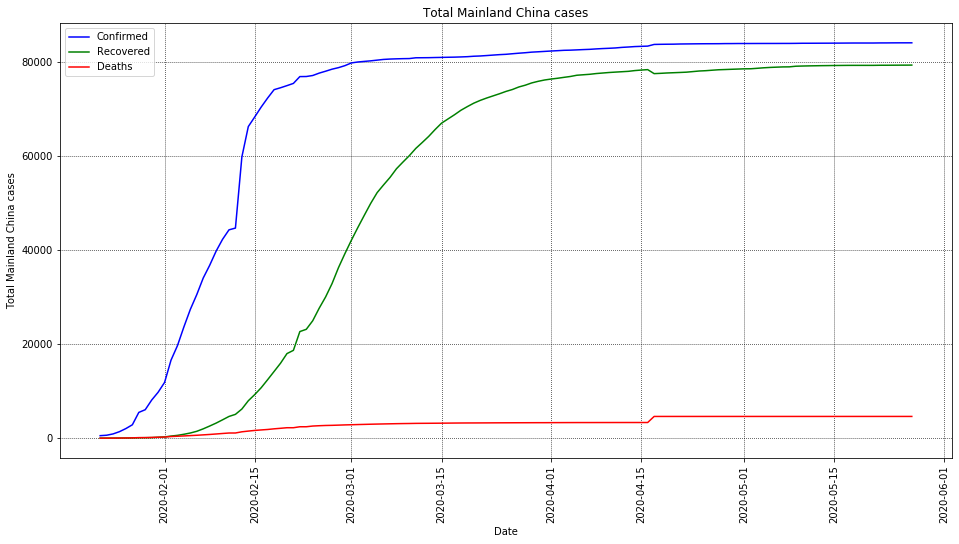

In [20]:
def plot_time_variation_all(df, title='Mainland China', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.lineplot(x="Date", y='Confirmed', data=df, color='blue', label='Confirmed')
    g = sns.lineplot(x="Date", y='Recovered', data=df, color='green', label='Recovered')
    g = sns.lineplot(x="Date", y='Deaths', data=df, color = 'red', label = 'Deaths')
    plt.xlabel('Date')
    plt.ylabel(f'Total {title} cases')
    plt.xticks(rotation=90)
    plt.title(f'Total {title} cases')
    ax.grid(color='black', linestyle='dotted', linewidth=0.75)
    plt.show()  

data_cn_agg = data_cn.groupby(['Date']).sum().reset_index()
plot_time_variation_all(data_cn_agg, size = 4)

除了湖北外的地區的痊癒數 (不知道為甚麼要特別觀察這個)

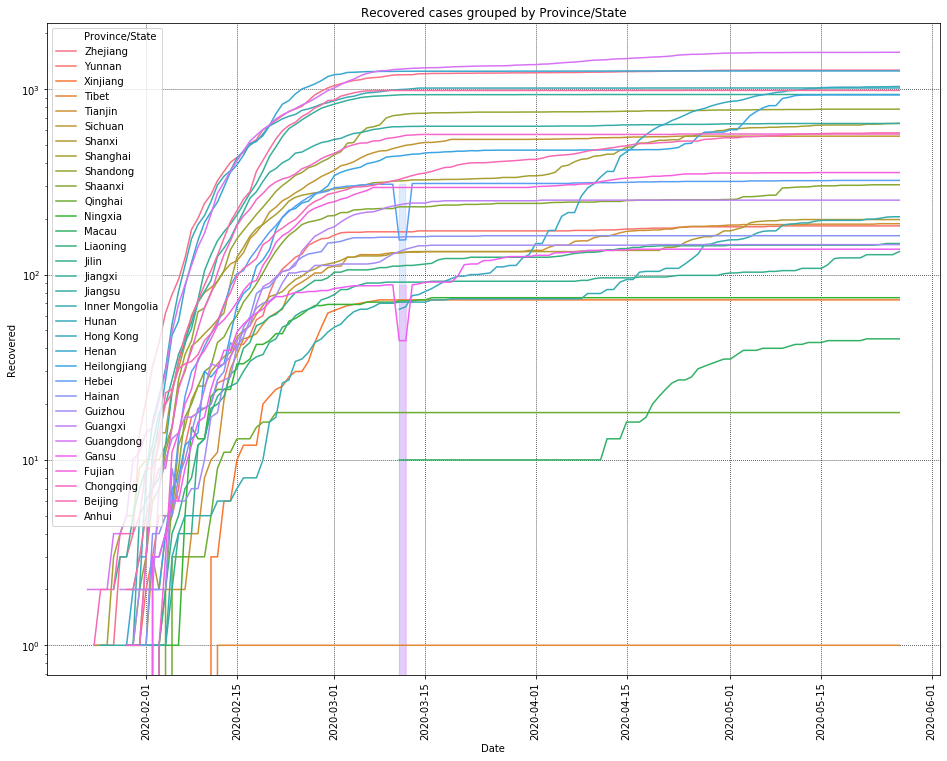

In [21]:
filtered_data_last = filtered_data_last.reset_index()
plot_time_variation(data_cn.loc[~(data_cn['Province/State'] == 'Hubei')],y = 'Recovered', size = 4, is_log = True)

至 5/27 止，每個省疫情的嚴重程度 (程式碼打這麼長，這張圖卻沒什麼卵用，只知道中國很多省都很嚴重)

In [22]:
m = folium.Map(location=[30, 100], zoom_start=4)

folium.Choropleth(
    
    # 使用原本的程式碼會出現 cp-950 encoding 的問題，所以這一行改成 open(...) 的寫法，強制使用 utf-8 解碼
    geo_data = open(cn_geo_data, encoding = "utf-8-sig").read(),
    
    name='Confirmed cases - regions',
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.05,
    line_opacity=0.3,
).add_to(m)

radius_min = 2
radius_max = 40
weight = 1
fill_opacity = 0.2

_color_conf = 'red'
group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'Latitude']
    lon = filtered_data_last.loc[i, 'Longitude']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max

    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_conf, 
                        popup = _popup_conf, 
                        color = _color_conf, 
                        fill_opacity = fill_opacity,
                        weight = weight, 
                        fill = True, 
                        fillColor = _color_conf).add_to(group0)

group0.add_to(m)
folium.LayerControl().add_to(m)
m

作者繪製兩種死亡率，第一種是死亡數除以所有病例數，第二種是死亡數除以已康復病例數，因為疫情爆發初期康復人數遠低於死亡人數，會發現用康復人數算的死亡率會超過1

按照作者的說法:第一種死亡率是被低估的，因為死亡通常會在確診後至少幾天發生；第二種是高估了，因為死亡通常比恢復快得多。藉由繪出兩者的折線，可以得出真實的死亡率在兩者之間。

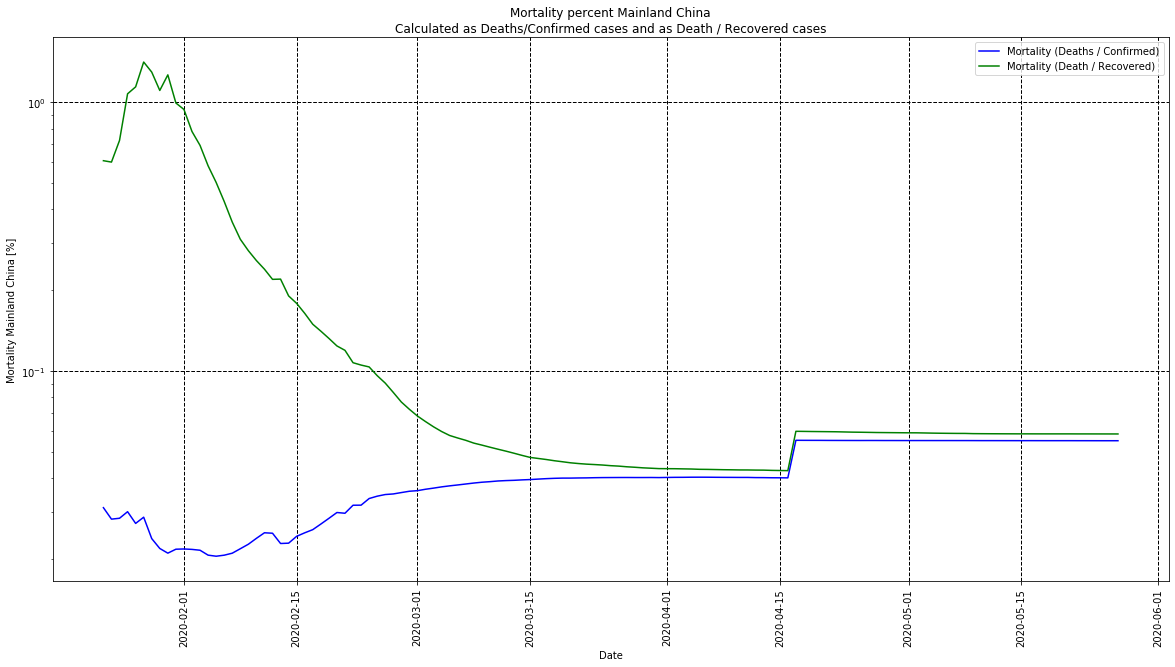

In [23]:
def plot_time_variation_mortality(df, title='Mainland China', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.lineplot(x="Date", y='Mortality (D/C)', data=df, color='blue', label='Mortality (Deaths / Confirmed)')
    g = sns.lineplot(x="Date", y='Mortality (D/R)', data=df, color='green', label='Mortality (Death / Recovered)')
    plt.xlabel('Date')
    ax.set_yscale('log')
    plt.ylabel(f'Mortality {title} [%]')
    plt.xticks(rotation=90)
    plt.title(f'Mortality percent {title}\nCalculated as Deaths/Confirmed cases and as Death / Recovered cases')
    ax.grid(color='black', linestyle='dashed', linewidth=1)
    plt.show()
    
data_cn_agg['Mortality (D/C)'] = data_cn_agg['Deaths'] / data_cn_agg['Confirmed']
data_cn_agg['Mortality (D/R)'] = data_cn_agg['Deaths'] / data_cn_agg['Recovered']
plot_time_variation_mortality(data_cn_agg, size = 5)

最後，作者表示中國的死亡率約為 3% ，但是好像沒有用 code 驗證，這裡附上程式...發現應該是 5.5% 到 5.8 % 才對

In [24]:
print('Death / Confirmed: ', data_cn_agg['Mortality (D/C)'][len(data_cn_agg) - 1])
print('Death / Recovered: ', data_cn_agg['Mortality (D/R)'][len(data_cn_agg) - 1])

Death / Confirmed:  0.05514469835683542
Death / Recovered:  0.05843738581526327


## 分析世界資料

首先將 `data_df` 中相同國家且相同日期的資料合併，存入 `data_wd` ，並將相同國家牌再一起，並且將日期由新到舊排序，一樣將最新日期 (5/27) 存入 `filtered_data_ct_last`，`data_ct` 跟 `data_wd` 是一樣的資料

In [25]:
data_wd = data_df.copy()
data_wd = pd.DataFrame(data_wd.groupby(['Country/Region', 'Date'])['Confirmed', 'Recovered', 'Deaths'].sum()).reset_index()
data_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
data_wd = data_wd.sort_values(by = ['Country','Date'], ascending = False)

data_ct = data_wd.sort_values(by = ['Country','Date'], ascending = False)
filtered_data_ct_last = data_wd.drop_duplicates(subset = ['Country'], keep = 'first')
data_ct_agg = data_ct.groupby(['Date']).sum().reset_index()

查看 `data_wd`

In [26]:
data_wd

,Country,Date,Confirmed,Recovered,Deaths
15917,Zimbabwe,2020-05-27,132.0,25.0,4.0
15916,Zimbabwe,2020-05-26,56.0,25.0,4.0
15915,Zimbabwe,2020-05-25,56.0,25.0,4.0
15914,Zimbabwe,2020-05-24,56.0,25.0,4.0
15913,Zimbabwe,2020-05-23,56.0,18.0,4.0
...,...,...,...,...,...
4,Afghanistan,2020-02-28,1.0,0.0,0.0
3,Afghanistan,2020-02-27,1.0,0.0,0.0
2,Afghanistan,2020-02-26,1.0,0.0,0.0
1,Afghanistan,2020-02-25,1.0,0.0,0.0


查看 `filtered_data_ct_last`

In [27]:
filtered_data_ct_last

,Country,Date,Confirmed,Recovered,Deaths
15917,Zimbabwe,2020-05-27,132.0,25.0,4.0
15848,Zambia,2020-05-27,1057.0,779.0,7.0
15777,Yemen,2020-05-27,256.0,10.0,53.0
15729,Western Sahara,2020-05-27,9.0,6.0,1.0
15676,West Bank and Gaza,2020-05-27,434.0,365.0,3.0
...,...,...,...,...,...
422,Angola,2020-05-27,71.0,18.0,4.0
353,Andorra,2020-05-27,763.0,676.0,51.0
266,Algeria,2020-05-27,8857.0,5129.0,623.0
173,Albania,2020-05-27,1050.0,812.0,33.0


以下三項觀察資料都沒什麼卵用
查看確診數前 30 高的國家
查看痊癒數前 30 高的國家
查看死亡數前 30 高的國家

In [28]:
# plot_count('Country', 'Confirmed', 'Confirmed cases - all World', filtered_data_ct_last, size=4)
# plot_count('Country', 'Recovered', 'Recovered - all World', filtered_data_ct_last, size=4)
# plot_count('Country', 'Deaths', 'Deaths - all World', filtered_data_ct_last, size=4)

全世界的確診、康復、死亡數。 4/2 確診數達100萬，康復數達20萬，死亡數達5萬 (沒什麼卵用的標註)

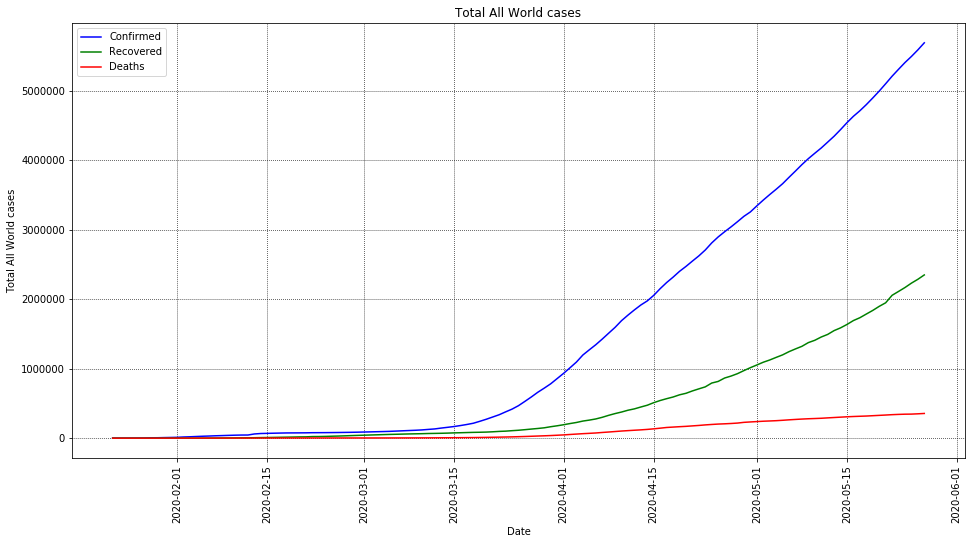

In [29]:
plot_time_variation_all(data_ct_agg, 'All World', size=4)

`data_select_agg` 是將 `data_ct` 的雷為順序反過來，變成國家由A到Z，日期由舊到新

In [30]:
data_select_agg = data_ct.groupby(['Country', 'Date']).sum().reset_index()

為 `data_select_agg` 新增一個欄位 'Active'，代表確診扣掉死亡跟康復

In [31]:
data_select_agg['Active'] = data_select_agg['Confirmed'] - data_select_agg['Deaths'] - data_select_agg['Recovered']

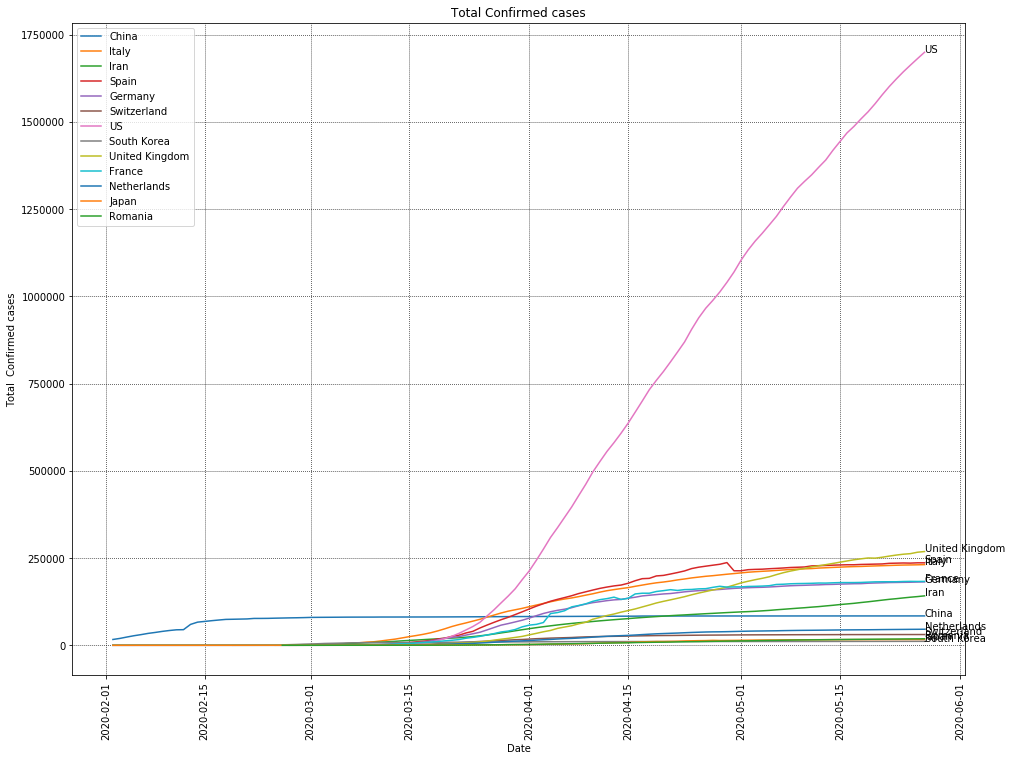

In [32]:
def plot_time_variation_countries(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1,1, figsize=(4 * size, 3 * size))
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-02-01')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    plt.show()
    
countries = ['China', 'Italy', 'Iran', 'Spain', 'Germany', 'Switzerland', 'US', 
             'South Korea', 'United Kingdom', 'France', 'Netherlands', 'Japan', 'Romania']
plot_time_variation_countries(data_select_agg, countries, size = 4)

還有痊癒數和死亡數的圖，因為大同小異，所以略過不畫

接下來使用對數圖觀察幾個國家的確診數，在圖中可以發現美國、英國等感染人數多且對數曲線斜率偏高；韓國、日本雖然前期增長很快，然而 4/1 日之後韓國的斜率幾乎是0，日本也在 5/1 後達到相同的低成長，代表疫情已經受到控制，而中國...作者暫且沒有提到。

很明顯可以看出美國在三月份對數曲線的斜率一直無法下降，而義大利則慢慢趨於平緩，然後美國的確診數在 3/25 前後超越了義大利。相同的觀察可以套用在荷蘭和南韓的比較。也就是說，在同一個時間點，若A國的對數曲線斜率大於B國，則確診數在之後超越B國的可能性是很大的。目前這張圖還舉不出反例，比較接近反例的是日本和羅馬尼亞的比較，按照曲線的趨勢來看，日本應該要在3/15把疫情壓下來，然而在3/15至4/15日本的疫情又有點失控，所以最後確診人數跟羅馬尼亞差不多。

作者也利用他的家鄉羅馬尼亞作為示範，儘管感染人數相對較低，羅馬尼亞現在的斜率是比義大利高的，是一個警訊。

雖然上述的比較方法忽略了人口基數、人口密度、土地面積，但是仍有一定的參考價值。同時我也把台灣的曲線放上去，發現3/15到4月有失控，查了一下[CDC](https://www.cdc.gov.tw/Bulletin/List/MmgtpeidAR5Ooai4-fgHzQ?page=19) 才發現原來是境外返台潮。

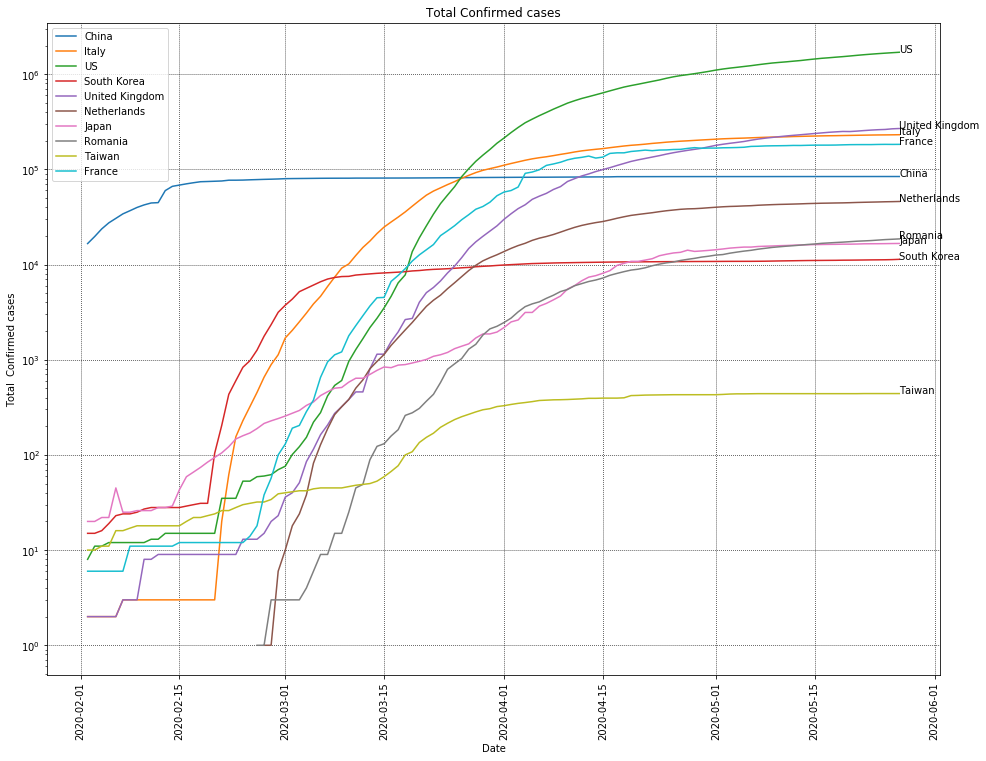

In [33]:
# 原圖包含更多國家的曲線，我只有取比較能說明這張圖用處的幾個國家
countries = ['China','Italy', 'US', 'South Korea', 'United Kingdom',\
             'Netherlands', 'Japan', 'Romania', 'Taiwan', 'France']
plot_time_variation_countries(data_select_agg, countries, size=4, is_log=True)

# begin---------------------------------------------

# 美國

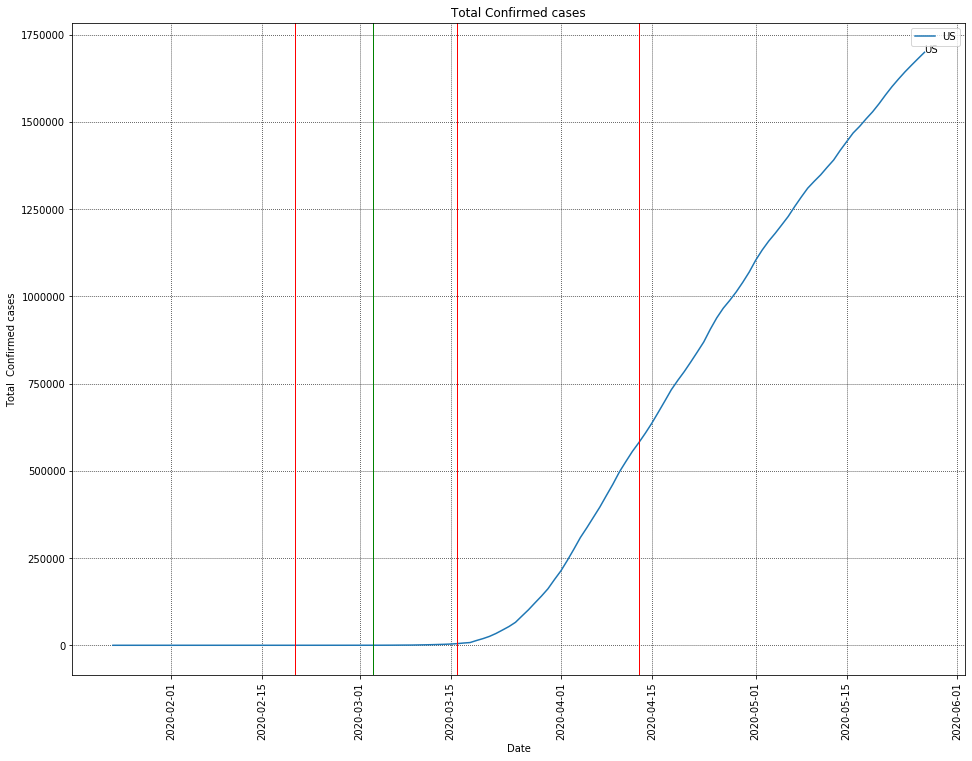

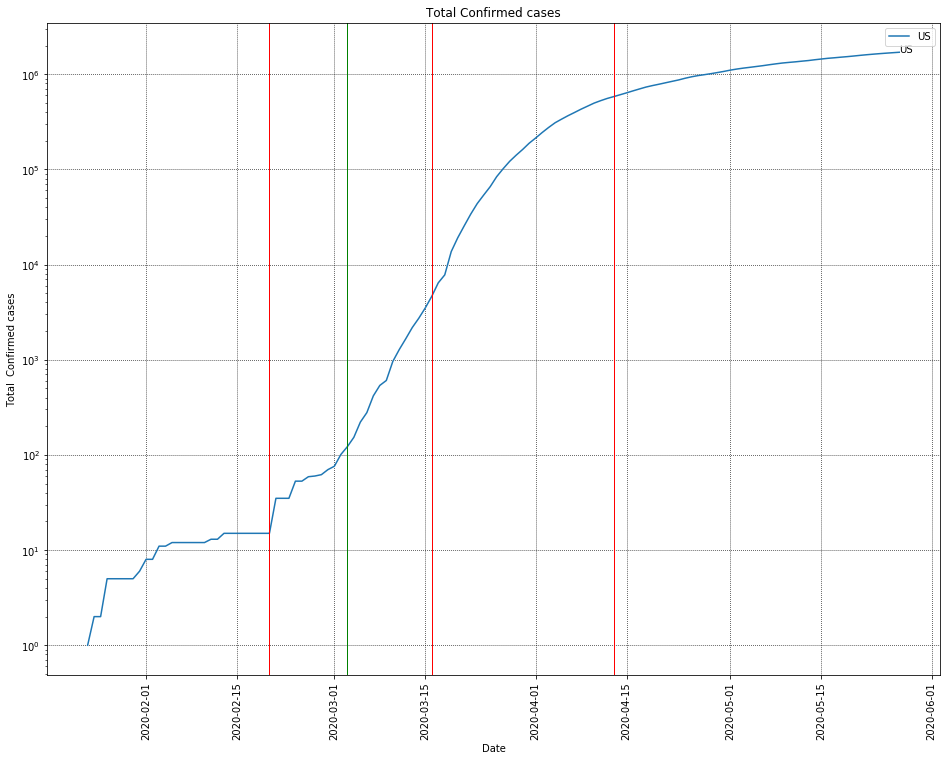

In [34]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line
    plt.axvline(x = '2020-02-20', linewidth = 1, color = 'red')
    plt.axvline(x = '2020-03-03', linewidth = 1, color = 'g')
    plt.axvline(x = '2020-03-16', linewidth = 1, color = 'red')
    plt.axvline(x = '2020-04-13', linewidth = 1, color = 'red')

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.show()

countries = ['US']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 南韓

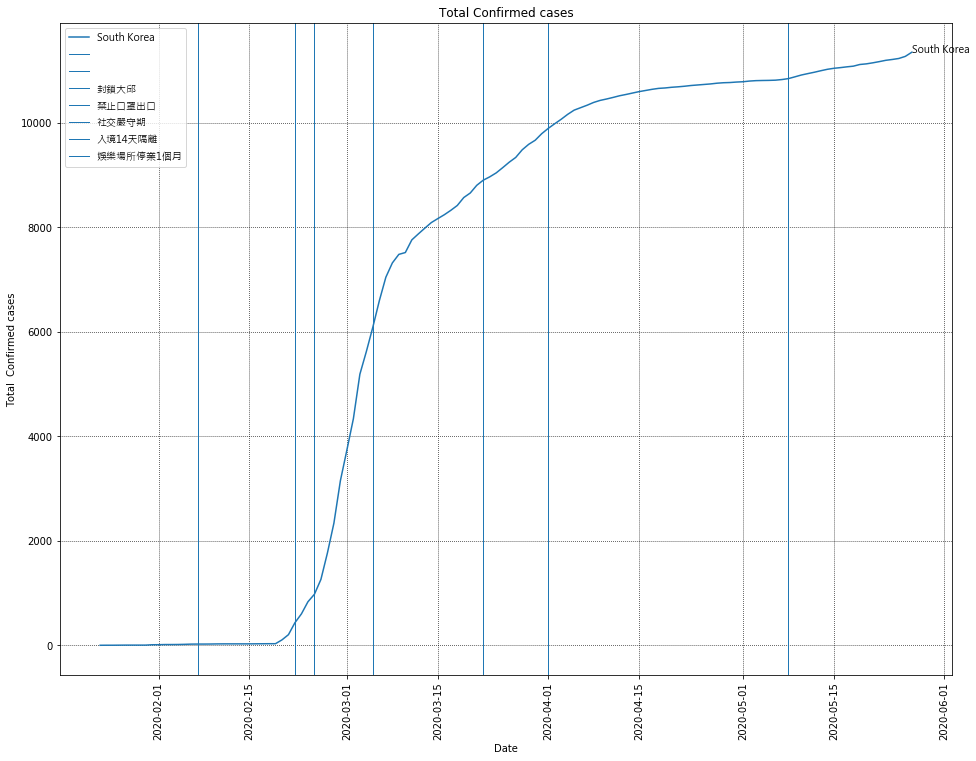

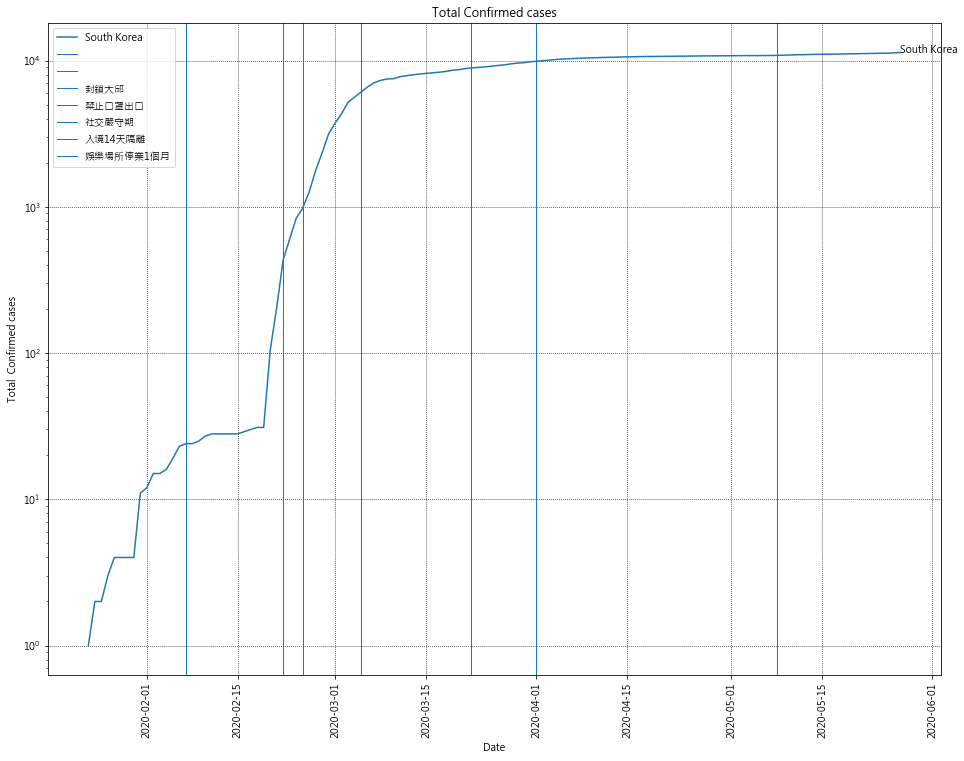

In [35]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line
    plt.axvline(x = '2020-02-07', linewidth = 1, label = u' ')
    plt.axvline(x = '2020-02-22', linewidth = 1, label = u' ')
    plt.axvline(x = '2020-02-25', linewidth = 1, label = u'封鎖大邱')
    plt.axvline(x = '2020-03-05', linewidth = 1, label = u'禁止口罩出口')
    plt.axvline(x = '2020-03-22', linewidth = 1, label = u'社交嚴守期')
    plt.axvline(x = '2020-04-01', linewidth = 1, label = u'入境14天隔離')
    plt.axvline(x = '2020-05-08', linewidth = 1, label = u'娛樂場所停業1個月')


    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['South Korea']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 俄羅斯

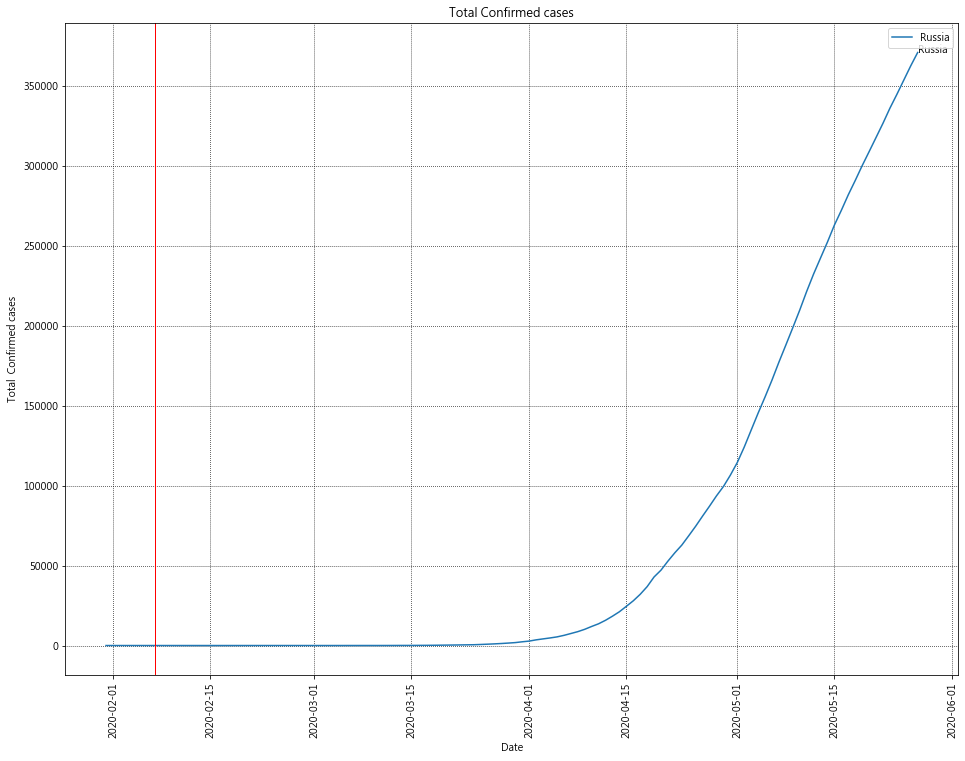

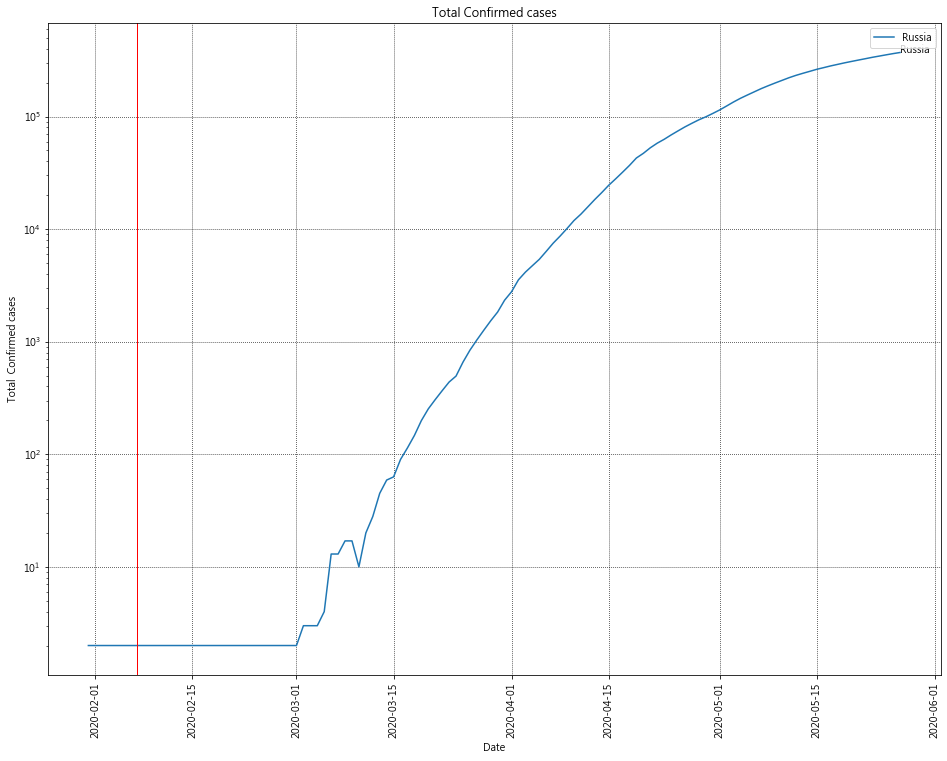

In [36]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line
    plt.axvline(x = '2020-02-07', linewidth = 1, color = 'r', label = u'')

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['Russia']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 日本

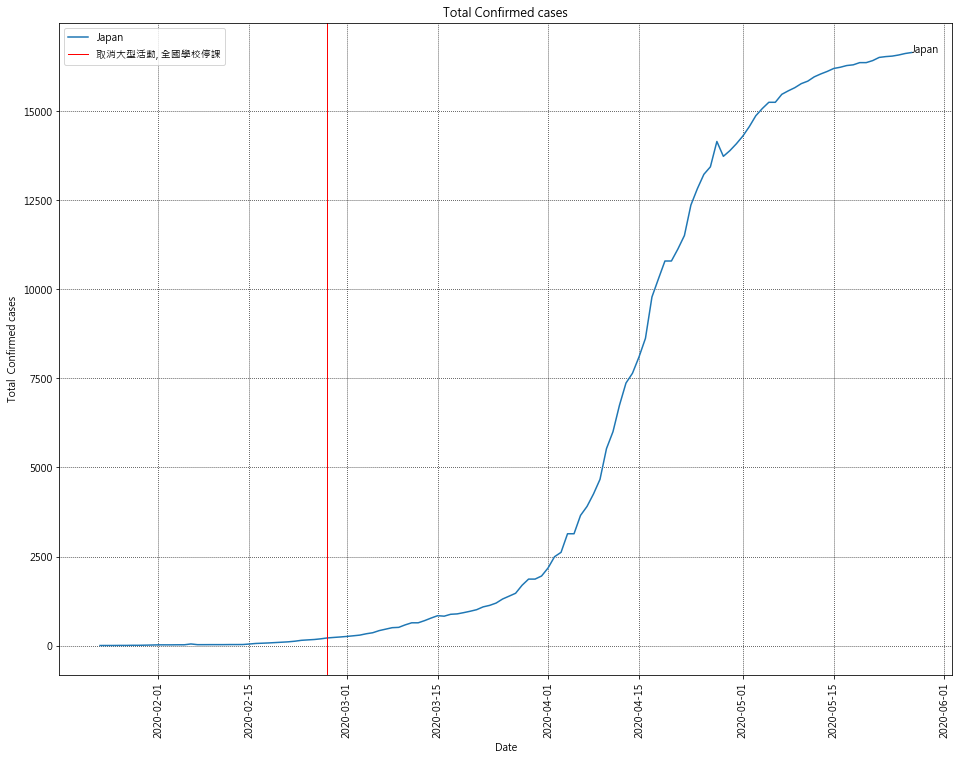

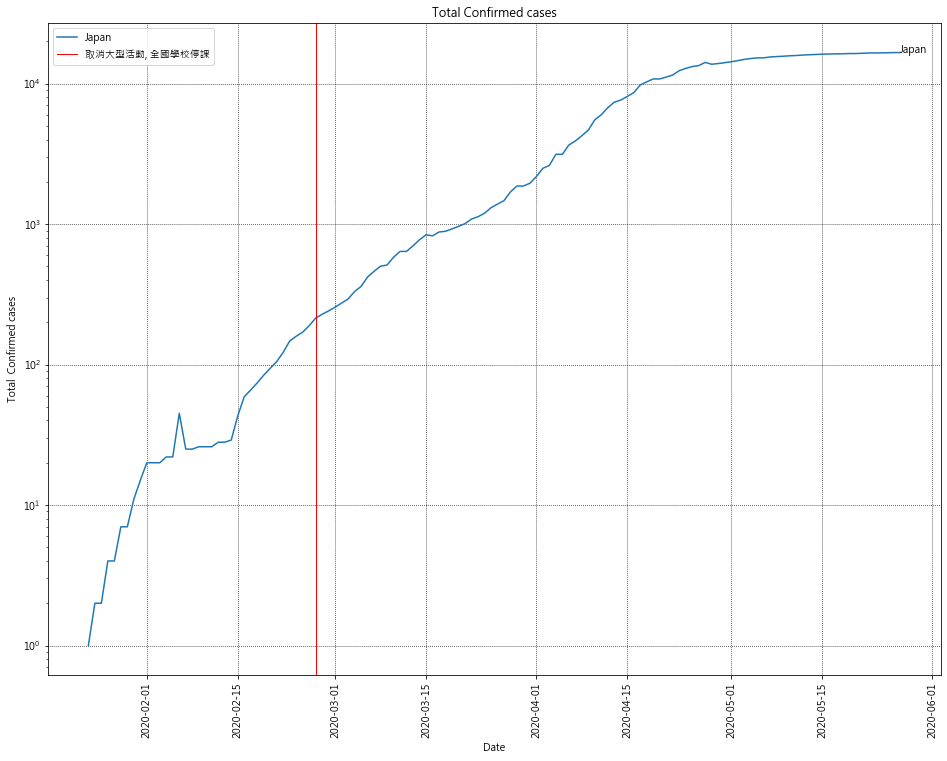

In [37]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line
    plt.axvline(x = '2020-02-27', linewidth = 1, color = 'r', label = u'取消大型活動, 全國學校停課')

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['Japan']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 荷蘭

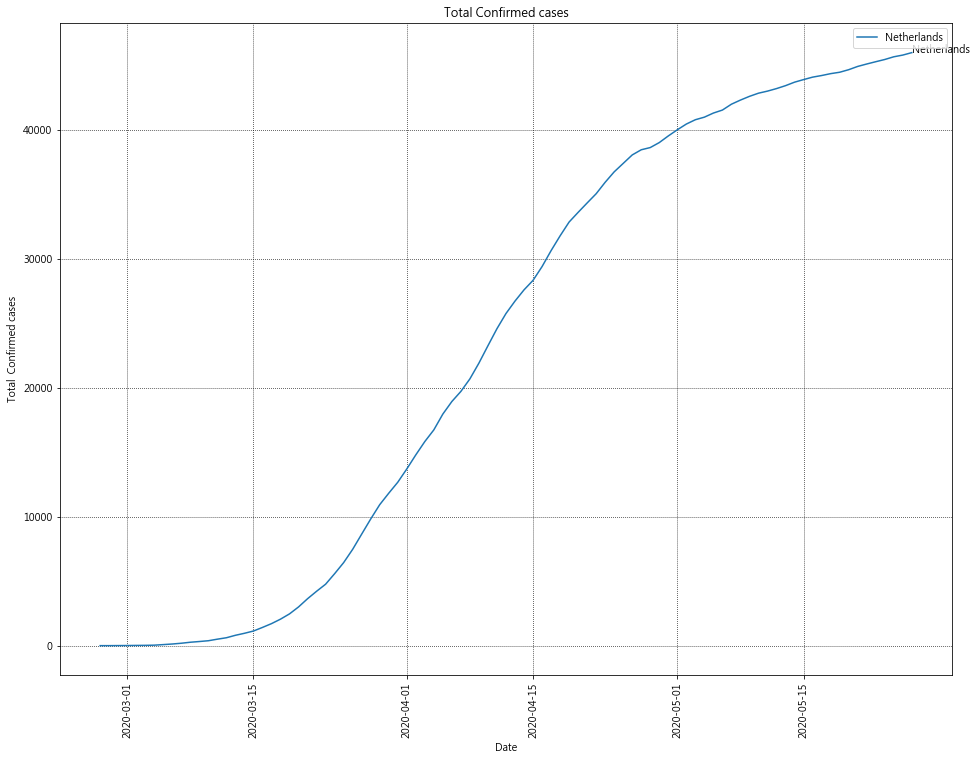

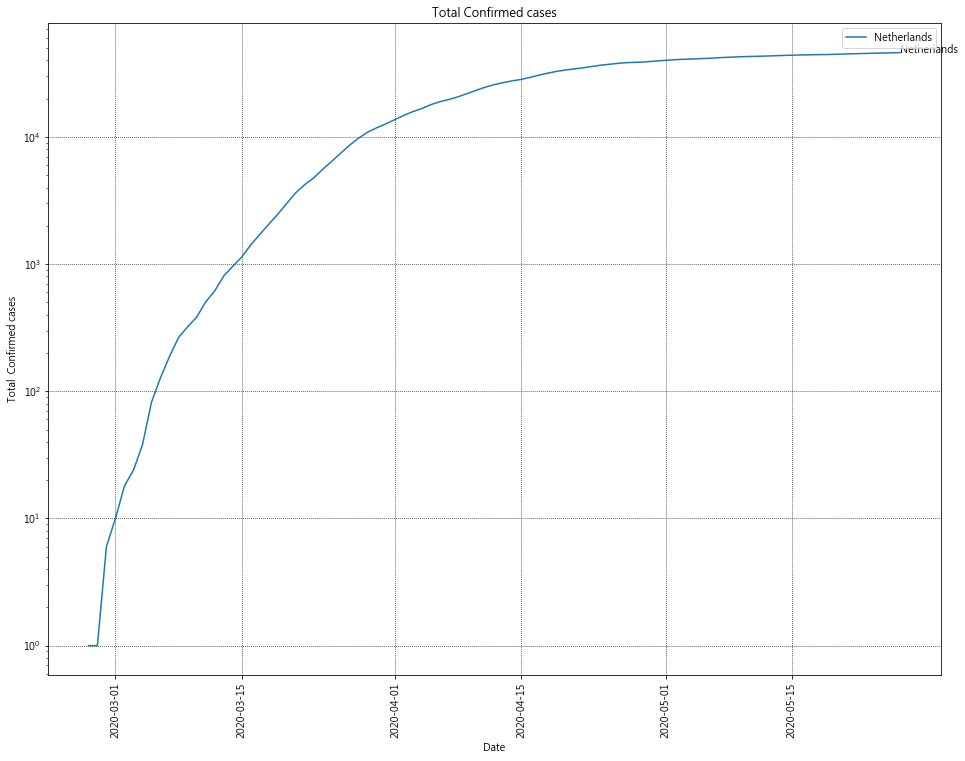

In [39]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['Netherlands']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 印度

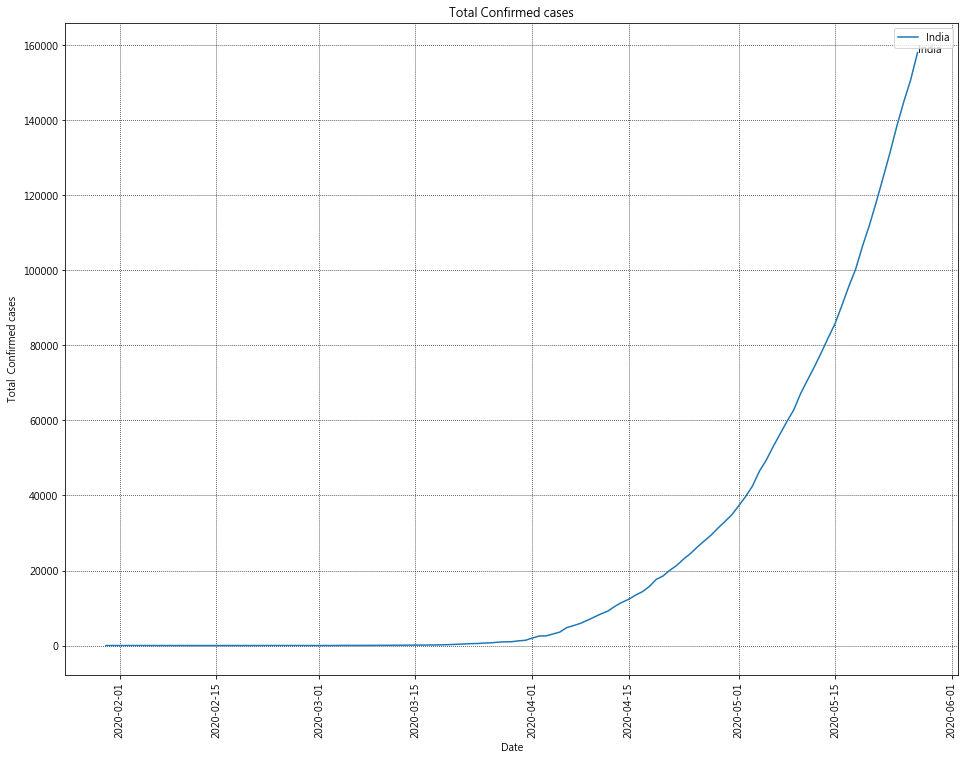

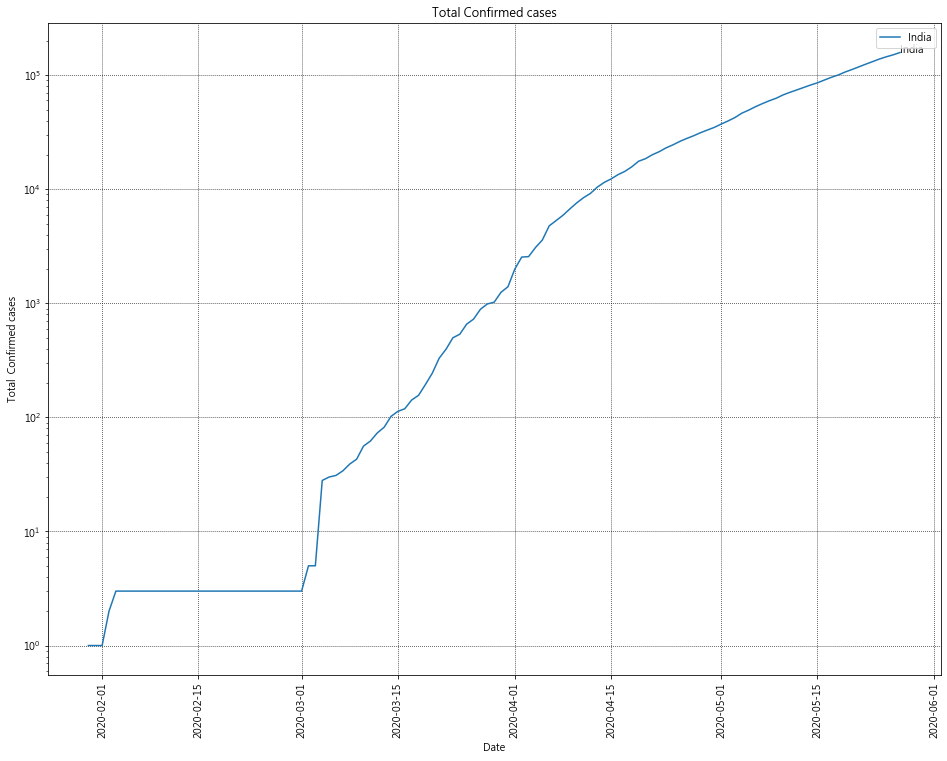

In [41]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['India']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 英國

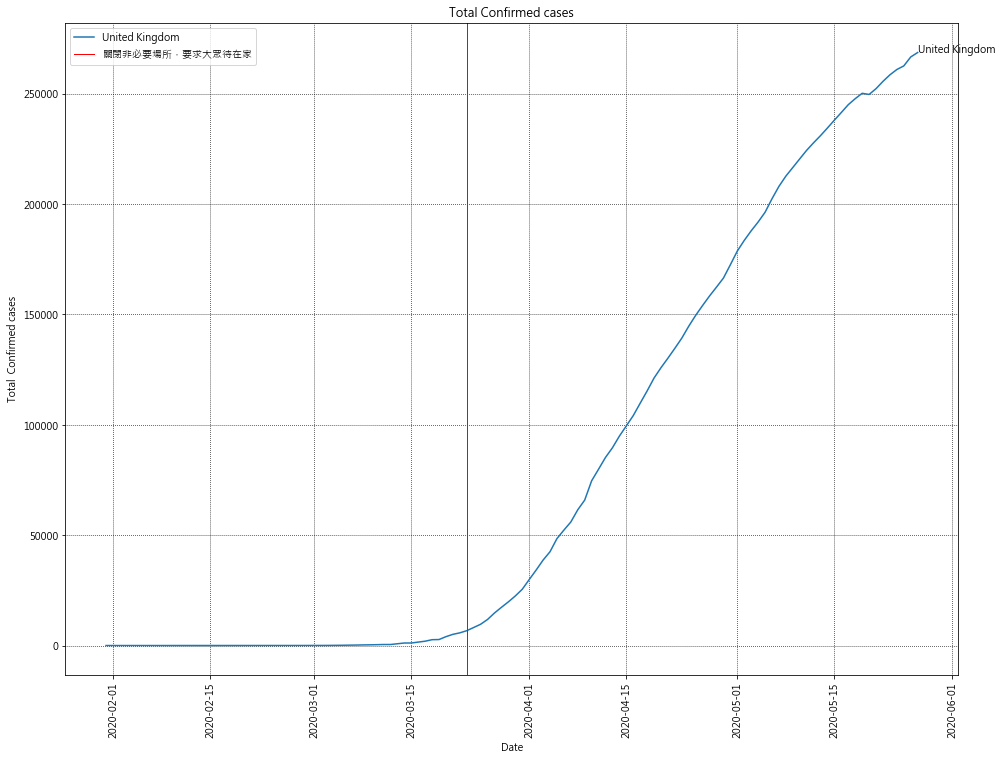

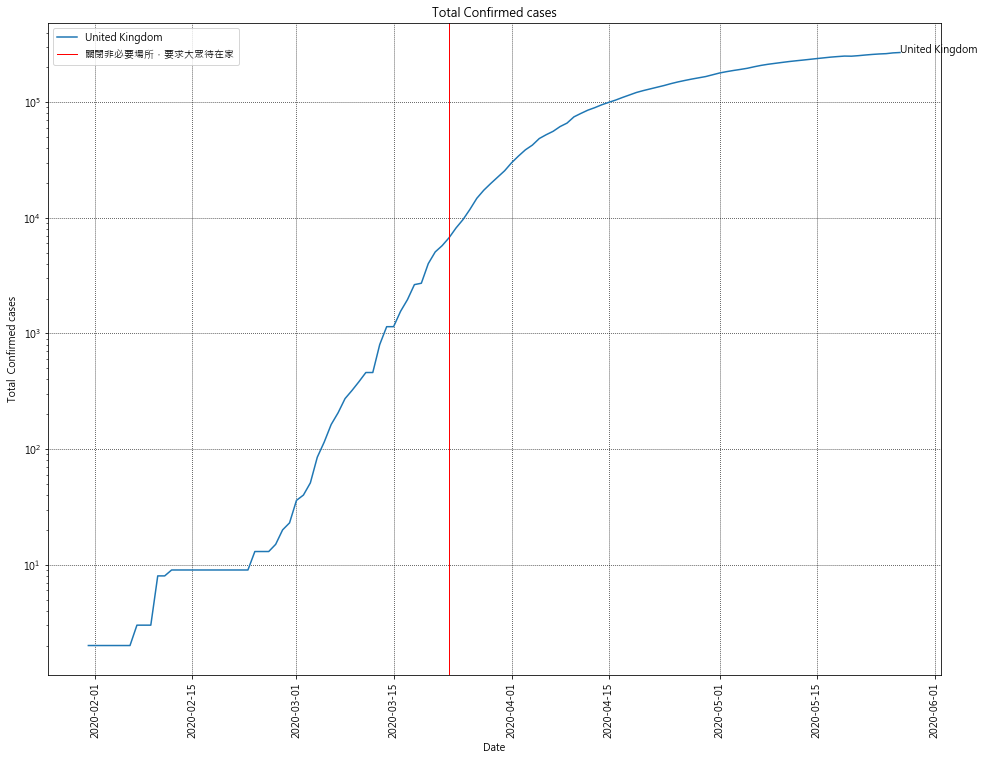

In [44]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line
    plt.axvline(x = '2020-03-23', linewidth = 1, color = 'r', label = u'關閉非必要場所，要求大眾待在家')

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['United Kingdom']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# 台灣

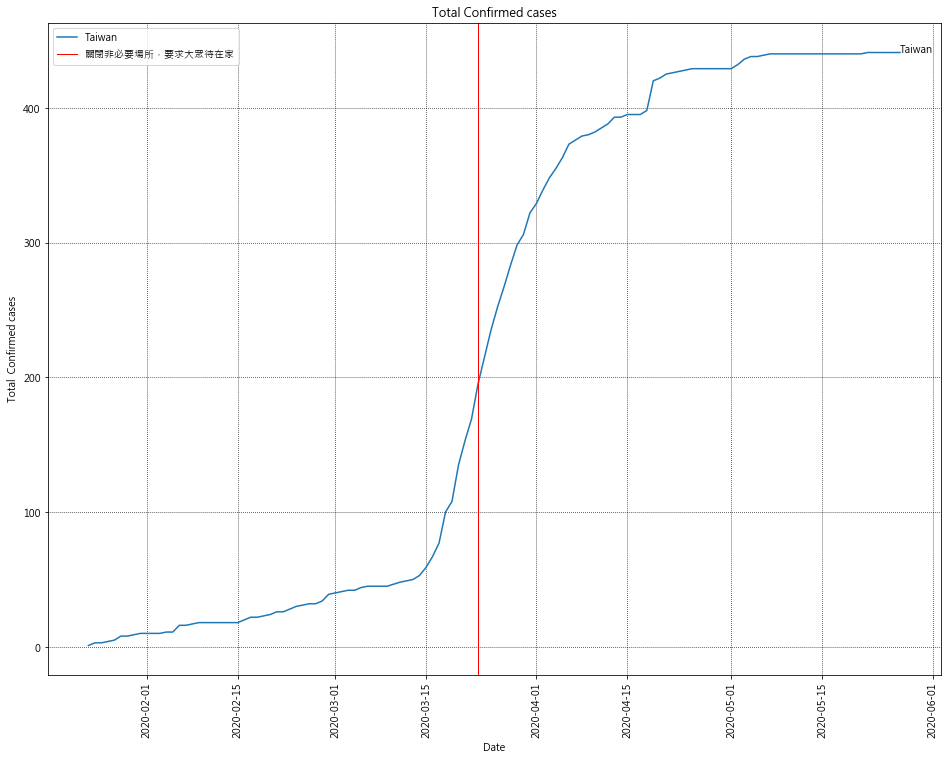

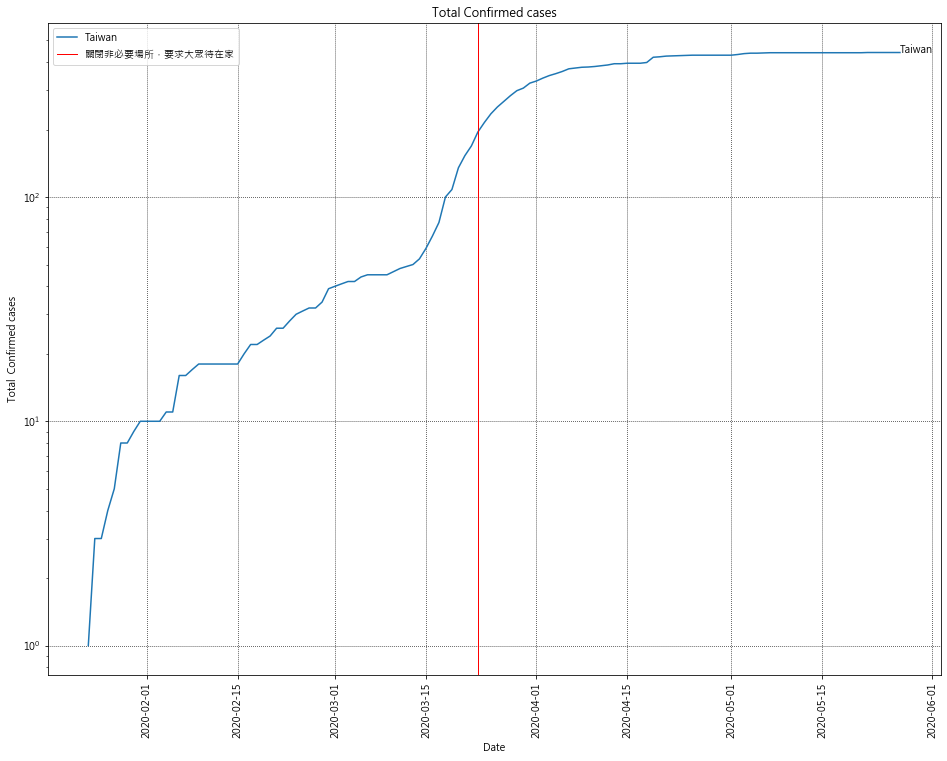

In [46]:
def plot_time_variation_countries2(df, countries, case_type = 'Confirmed', size = 3, is_log = False):
    f, ax = plt.subplots(1, 1, figsize=(4 * size, 3 * size))
    plt.rc('font', family = 'Microsoft JhengHei')
    for country in countries:
        df_ = df[(df['Country'] == country) & (df['Date'] > '2020-01-22')] 
        g = sns.lineplot(x = "Date", y=case_type, data = df_,  label=country)  
        ax.text(max(df_['Date']), (df_.loc[df_['Date'] == max(df_['Date']), case_type]), str(country))
    plt.xlabel('Date')
    plt.ylabel(f'Total  {case_type} cases')
    plt.title(f'Total {case_type} cases')
    plt.xticks(rotation=90)
    if(is_log):
        ax.set(yscale = "log")
    ax.grid(color = 'black', linestyle = 'dotted', linewidth = 0.75)
    
    #draw vertical line

    #plt.text(0.5, 0.5, '限制中國入境美國')
    plt.legend()
    plt.show()

countries = ['Taiwan']
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=False)
plot_time_variation_countries2(data_select_agg, countries, size=4, is_log=True)

# end---------------------------------------------

作者對痊癒跟死亡的對數圖基本上也沒什麼見解，所以也略過

In [ ]:
# plot_time_variation_countries(data_select_agg, countries,case_type = 'Recovered', size=4, is_log=True)
# plot_time_variation_countries(data_select_agg, countries,case_type = 'Deaths', size=4, is_log=True)

扣除痊癒和死亡的病例對數圖，可以發現有些國家的 Active Case 已經下降到原本的 80% (十進位刻度)以下

我個人覺得在疫情受到控制的條件下可以當作醫療量能的指標，不過對於預測確診人數沒什麼用

In [ ]:
# plot_time_variation_countries(data_select_agg, countries,case_type = 'Active', size=4, is_log=True)

接著作者挑出確診數 500 以下且 Active Case 小於 Active Case 最大值的 67% 的國家，並將最大值及目前的值印出來

我把百分比也印出來了，然而沒什麼用

In [ ]:
# descent_active_case_countries = []
# for country in data_select_agg.Country.unique():
#     df = data_select_agg.loc[data_select_agg.Country == country]
#     max_active = max(df['Active'])
#     last_active = df.loc[df['Date']==max(df['Date']), 'Active'].values[0]
#     if((last_active < 0.67 * max_active) & (max_active > 500)):
#         print(f"country: {country} max active cases: {max_active} last day active cases: {last_active} [{round(100 * last_active / max_active, 2)} %]")
#         descent_active_case_countries.append(country)

# print()
# print(descent_active_case_countries)

In [ ]:
# def plot_time_variation_countries_group_of_features(df, countries, features,title, row, col):
#     i = 0
#     sns.set_style('whitegrid')
#     plt.figure()
#     fig, ax = plt.subplots(row, col, figsize=(15, 12))

#     for country in countries:
#         plt.subplot(row, col,i + 1)
#         df_ = df[(df['Country']==country) & (df['Date'] > '2020-02-01')] 
#         df_['date'] = df_['Date'].apply(lambda x: x.timetuple().tm_yday)
#         for feature in features:
#             g = sns.lineplot(x="date", y=feature, data=df_,  label=feature)
#         plt.title(f'{country}') 
#         plt.xlabel('')
#         i = i + 1
#     fig.suptitle(title)
#     plt.show()  

這裡作者畫出 20 張痊癒人數跟 Active Case 的比較圖，然而卻沒有任何見解，這裡我簡化成 12 張並加入美國跟台灣

這張圖只能看出 Active 往下降跟 Recover 往上升代表疫情受到控制，也許交叉點可以做進一步分析吧...

In [ ]:
# countries = ['Austria', 'China', 'Germany', 'Iran', 
#              'South Korea', 'Italy', 'Spain', 'France',
#              'Japan', 'Romania', 'US', 'Taiwan']
# features = ['Recovered', 'Active']
# plot_time_variation_countries_group_of_features(data_select_agg, countries, features, 'Recovered (cumulative) vs. Active - cases vs. day of year', 3, 4)

各地區確診數的熱圖，可以看出確診多出現在人口密集或醫療落後的區域

In [ ]:
# data_ps = data_df.sort_values(by = ['Province/State','Date'], ascending=False)
# filtered_data_ps = data_ps.drop_duplicates(subset = ['Province/State'], keep='first').reset_index()

# data_cr = data_df.sort_values(by = ['Country/Region','Date'], ascending=False)
# filtered_data_cr = data_cr.drop_duplicates(subset = ['Country/Region'], keep='first').reset_index()

# filtered_data_cr = filtered_data_cr.loc[~filtered_data_cr.Latitude.isna()]
# filtered_data_cr = filtered_data_cr.loc[~filtered_data_cr.Longitude.isna()]
# filtered_data = pd.concat([filtered_data_cr, filtered_data_ps], axis=0).reset_index()

# m = folium.Map(location=[0,0], zoom_start=2)
# max_val = max(filtered_data['Confirmed'])
# HeatMap(data=filtered_data[['Latitude', 'Longitude', 'Confirmed']],\
#         radius=15, max_zoom=12).add_to(m)
# m

全球確診數隨著時間的進展 (這個圖要跑很久，而且沒什麼卵用)

In [ ]:
# data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Date'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
# data_all_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
# data_all_wd = data_all_wd.sort_values(by = ['Country','Date'], ascending=False)
# filtered_all_wd_data_last = data_all_wd.drop_duplicates(subset = ['Country'],keep='first')
# filtered_all_wd_data_last.loc[filtered_all_wd_data_last['Country']=='Mainland China', 'Country'] = 'China'

# # import plotly.express as px
# # mindate = min(data_df['Date'])
# # maxdate = max(data_df['Date'])
# # print(f"Date min/max: {mindate}, {maxdate}")
# # data_wd_df = data_df.copy()
# # data_wd_df['Days'] = data_wd_df['Date'].apply(lambda x: (x - dt.datetime.strptime('2020-01-21', "%Y-%m-%d")).days)
# # data_wd_df.loc[data_wd_df.Confirmed.isna(), 'Confirmed'] = 0
# # data_wd_df['Size'] = np.round(5 * np.sqrt(data_wd_df['Confirmed']),0)
# # max_confirmed = max(data_wd_df['Confirmed'])
# # min_confirmed = min(data_wd_df['Confirmed'])
# # hover_text = []
# # for index, row in data_wd_df.iterrows():
# #     hover_text.append(('Date: {}<br>'+
# #                        'Country/Region: {}<br>'+
# #                        'Province/State: {}<br>'+
# #                       'Confirmed: {}<br>'+
# #                       'Recovered: {}<br>'+
# #                       'Deaths: {}<br>').format(row['Date'], 
# #                                             row['Country/Region'],
# #                                             row['Province/State'],
# #                                             row['Confirmed'],
# #                                             row['Recovered'],
# #                                             row['Deaths']))
# # data_wd_df['hover_text'] = hover_text
# # fig = px.scatter_geo(data_wd_df, lon='Longitude', lat='Latitude', color="Confirmed",
# #                      hover_name="hover_text", size="Size",
# #                      animation_frame="Days",
# #                      projection="natural earth",
# #                      range_color =[min_confirmed,max_confirmed],
# #                     width=700,height=525)
# # fig.show()

和中國的資料一樣，作者繪製兩種全世界的死亡率，第一種是死亡數除以所有病例數，第二種是死亡數除以已康復病例數

In [ ]:
# data_ct_agg = data_all_wd.groupby(['Date']).sum().reset_index()

# data_ct_agg['Mortality (D/C)'] = data_ct_agg['Deaths'] / data_ct_agg['Confirmed'] * 100
# data_ct_agg['Mortality (D/R)'] = data_ct_agg['Deaths'] / data_ct_agg['Recovered'] * 100
# plot_time_variation_mortality(data_ct_agg, title = ' - All world', size = 3)

以“死亡/康復”計算的死亡率以及“死亡/確診病例”仍在增加。 這主要是由於最初意大利和伊朗等國家的死亡人數急劇增加，然後是西班牙，法國，英國，美國。

讓我們分別看這些國家。

In [ ]:
# data_all_wd = pd.DataFrame(data_df.groupby(['Country/Region', 'Date'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
# data_all_wd.columns = ['Country', 'Date', 'Confirmed', 'Recovered', 'Deaths' ]
# data_all_wd = data_all_wd.sort_values(by = ['Country','Date'], ascending=False)
# data_italy = data_all_wd[data_all_wd['Country']=='Italy']
# data_it_agg = data_italy.groupby(['Date']).sum().reset_index()

# data_it_agg['Mortality (D/C)'] = data_it_agg['Deaths'] / data_it_agg['Confirmed'] * 100
# data_it_agg['Mortality (D/R)'] = data_it_agg['Deaths'] / data_it_agg['Recovered'] * 100

# plot_time_variation_mortality(data_it_agg, title = ' - Italy', size = 3)

意大利的高死亡率（並且仍在上升）很可能是由於延遲了社會隔離措施以及居民不願遵守規定的結果。從3月1日開始，這兩種比率都在上升，並且這種趨勢很可能會繼續，因為在這個人口稠密，人口稠密的歐洲國家中，社會隔離規則的執行緩慢。

**2020-04-06** 我們可以觀察到死亡率下降的最初跡象，該數字是根據“死亡報告”確定的。

**2020-04-11** 幾天前觀察到的趨勢仍在繼續。

In [ ]:
# data_iran = data_all_wd[data_all_wd['Country']=='Iran']
# data_ir_agg = data_iran.groupby(['Date']).sum().reset_index()

# data_ir_agg['Mortality (D/C)'] = data_ir_agg['Deaths'] / data_ir_agg['Confirmed'] * 100
# data_ir_agg['Mortality (D/R)'] = data_ir_agg['Deaths'] / data_ir_agg['Recovered'] * 100

# plot_time_variation_mortality(data_ir_agg, title = ' - Iran', size = 3)

從3月7日開始，我們可以觀察到一個奇怪的模式，這似乎表明已確認病例和已恢復病例之間存在一定的相關性。 同樣在這種情況下，我們可以通過兩個指標觀察到死亡率增加。

**2020-04-10** 我們可以觀察到死亡/康復後死亡率下降的趨勢。

In [ ]:
# data_sk = data_all_wd[data_all_wd['Country']=='South Korea']
# data_sk_agg = data_sk.groupby(['Date']).sum().reset_index()

# data_sk_agg['Mortality (D/C)'] = data_sk_agg['Deaths'] / data_sk_agg['Confirmed'] * 100
# data_sk_agg['Mortality (D/R)'] = data_sk_agg['Deaths'] / data_sk_agg['Recovered'] * 100

# plot_time_variation_mortality(data_sk_agg, title = ' - South Korea', size = 3)

在韓國，起初採取了預防措施，可以將死亡病例與新確診病例的比率保持在較低水平（低於1％），而死亡病例與已恢復病例的比率現在已接近10％。 最近幾天，確診病例的死亡率開始上升，接近1％。

In [ ]:
# data_sp = data_all_wd[data_all_wd['Country']=='Spain']
# data_sp_agg = data_sp.groupby(['Date']).sum().reset_index()

# data_sp_agg['Mortality (D/C)'] = data_sp_agg['Deaths'] / data_sp_agg['Confirmed'] * 100
# data_sp_agg['Mortality (D/R)'] = data_sp_agg['Deaths'] / data_sp_agg['Recovered'] * 100

# plot_time_variation_mortality(data_sp_agg, title = ' - Spain', size = 3)

在西班牙，死亡率（死亡/確診）高於2％。 就流行病的發展而言，西班牙可能比意大利落後一個多星期。(?)

**2020-04-06** 我們可以觀察到死亡率下降的最初跡象，該數字是根據“死亡報告”確定的。

**2020-04-11** 幾天前觀察到的趨勢仍在繼續。

In [ ]:
# data_de = data_all_wd[data_all_wd['Country']=='Germany']
# data_de_agg = data_de.groupby(['Date']).sum().reset_index()

# data_de_agg['Mortality (D/C)'] = data_de_agg['Deaths'] / data_de_agg['Confirmed'] * 100
# data_de_agg['Mortality (D/R)'] = data_de_agg['Deaths'] / data_de_agg['Recovered'] * 100

# plot_time_variation_mortality(data_ir_agg, title = ' - Germany', size = 3)

我們可以觀察到，在德國，按死亡人數/確診人數計算的死亡率相當小（小於0.6％），而死亡/康復百分比則約為3％。 這是由於進行了大量的測試以及醫療系統的準備和能力所致，從而更好地反映了該病毒的實際發病率。

**2020-04-10** 德國的死亡率（死亡/恢復）開始逐漸降低，與“死亡/確診”的共同值趨於一致。

**2020-04-11** 幾天前觀察到的趨勢仍在繼續

In [ ]:
# data_us = data_all_wd[data_all_wd['Country']=='US']
# data_us_agg = data_us.groupby(['Date']).sum().reset_index()

# data_us_agg['Mortality (D/C)'] = data_us_agg['Deaths'] / data_us_agg['Confirmed'] * 100
# data_us_agg['Mortality (D/R)'] = data_us_agg['Deaths'] / data_us_agg['Recovered'] * 100

# plot_time_variation_mortality(data_us_agg, title = ' - US', size = 3)

**2020-04-11** 死亡率（按兩種度量）呈上升趨勢。

In [ ]:
# data_uk = data_all_wd[data_all_wd['Country']=='United Kingdom']
# data_uk_agg = data_uk.groupby(['Date']).sum().reset_index()

# data_uk_agg['Mortality (D/C)'] = data_uk_agg['Deaths'] / data_uk_agg['Confirmed'] * 100
# data_uk_agg['Mortality (D/R)'] = data_uk_agg['Deaths'] / data_uk_agg['Recovered'] * 100

# plot_time_variation_mortality(data_uk_agg, title = ' - UK', size = 3)

觀察兩種標準，英國的死亡率都在急劇上升。

**2020-04-10** 英國的死亡率（按這兩個指標）仍在上升。

**2020-04-11** 英國的死亡率（死亡/恢復）似乎在最後一天有所下降。 我們希望這將成為趨勢，因為通過另一指標（死亡/確診），趨勢仍在上升。

## 最後，仍然是一些比較圖，然後就沒了

In [ ]:
# def plot_time_variation_mortality_countries(df, countries):
#     i = 0
#     sns.set_style('whitegrid')
#     plt.figure()
#     fig, ax = plt.subplots(4,4,figsize=(18, 16))

#     for country in countries:
#         plt.subplot(4,4,i + 1)
#         df_ = df.loc[(df['Country']==country) & (df['Date'] > '2020-02-01')] 
#         df_['date'] = df_['Date'].apply(lambda x: x.timetuple().tm_yday)
#         df_['Mortality (D/C)'] = df_['Deaths'] / df_['Confirmed'] * 100
#         df_['Mortality (D/R)'] = df_['Deaths'] / df_['Recovered'] * 100
#         g = sns.lineplot(x="date", y='Mortality (D/C)', data=df_,  label='M (D/C)')
#         g = sns.lineplot(x="date", y='Mortality (D/R)', data=df_,  label='M (D/R)')
#         plt.title(f'{country}') 
#         ax[i//4, i%4].set_yscale('log')
#         plt.xlabel('')
#         i = i + 1
#     fig.suptitle('Mortality Deaths/Recovered (D/R) & Deaths/Confirmed (D/C)')
#     plt.show()  

In [ ]:
# countries = ['Austria', 'Azerbaijan', 'China', 'Croatia', 
#              'Denmark', 'Germany', 'Iceland', 'Iran', 
#              'Malaysia', 'New Zealand',  'South Korea', 'Switzerland', 
#              'Japan', 'Italy', 'US', 'Romania']
# plot_time_variation_mortality_countries(data_select_agg, countries)

In [ ]:
# def plot_time_variation_mortality_countries(df, countries, title='Mainland China', size=5):
#     f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
#     colors = ['red', 'blue', 'green', 'magenta', 'lightgreen', 'black']
#     for i, country in enumerate(countries):
#         dc_df = df.loc[df.Country == country].copy()
#         dc_df_agg = dc_df.groupby(['Date']).sum().reset_index()
#         dc_df_agg['Mortality (D/C)'] = dc_df_agg['Deaths'] / dc_df_agg['Confirmed'] * 100
#         dc_df_agg['Mortality (D/R)'] = dc_df_agg['Deaths'] / dc_df_agg['Recovered'] * 100
#         g = sns.lineplot(x="Date", y='Mortality (D/C)', data=dc_df_agg, linestyle='-', color=colors[i], label=f'Mortality (Deaths/Confirmed) - {country}')
#         ax.text(max(dc_df_agg['Date']), (dc_df_agg['Mortality (D/C)'].tail(1)), str(country))
#         g = sns.scatterplot(x="Date", y='Mortality (D/R)', data=dc_df_agg, linestyle='-.', color=colors[i],label=f'Mortality (Deaths/Recovered) - {country}')
#         ax.text(max(dc_df_agg['Date']), (dc_df_agg['Mortality (D/R)'].tail(1)), str(country))
#     plt.xlabel('Date')
#     ax.set_yscale('log')
#     plt.ylabel(f'Mortality {title} [%]')
#     plt.xticks(rotation=90)
#     plt.title(f'Mortality percent {title}\nCalculated as Deaths/Confirmed cases and as Death / Recovered cases')
#     ax.grid(color='black', linestyle='dashed', linewidth=1)
#     plt.show()  

# countries = ['US', 'Italy', 'China', 'South Korea', 'Japan', 'Romania']
# plot_time_variation_mortality_countries(data_all_wd, countries, '- selection of World Countries',5)